Getting a stochastic block matrix from networkx and determining what block each node is in.

In [1]:
import networkx as nx
import numpy as np

def SBM_adjacency(n, k, Pii, Pij):
    '''
    Returns the adjacency matrix of a stochastic block model on n nodes with k communities
    The edge prob within the same community is Pii
    The edhe prob across different communities is Pij
    '''
    sizes = np.zeros(k, dtype=int) + n//k
    probs = np.zeros((k,k)) + Pij
    np.fill_diagonal(probs, Pii)
    G = nx.stochastic_block_model(sizes, probs)
    return G

In [8]:
n = 10
k = 5
Pii = 0.5
Pij = 0 

G = SBM_adjacency(n,k,Pii,Pij)
blocks = nx.get_node_attributes(G, "block")
lst = [0,4]
nodesAt5 = [x for x,y in G.nodes(data=True) if (y['block'] in lst)]

In [26]:
blocks

{0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3, 8: 4, 9: 4}

In [31]:
nodesAt5

[0, 1, 8, 9]

In [9]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degree_sequence

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]

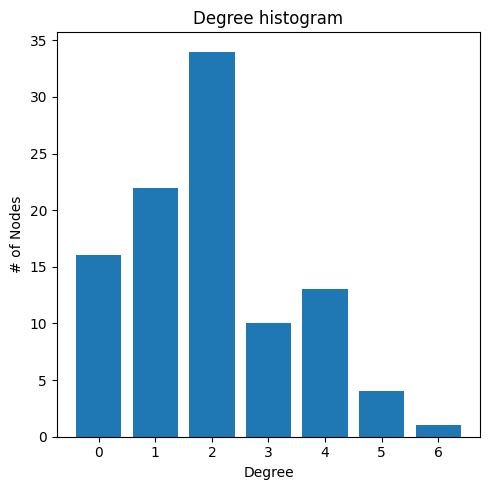

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.gnp_random_graph(100, 0.02, seed=10374196)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(5, 5))
axgrid = fig.add_gridspec(3, 3)
ax2 = fig.add_subplot(axgrid[:, :])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.savefig('test.png')

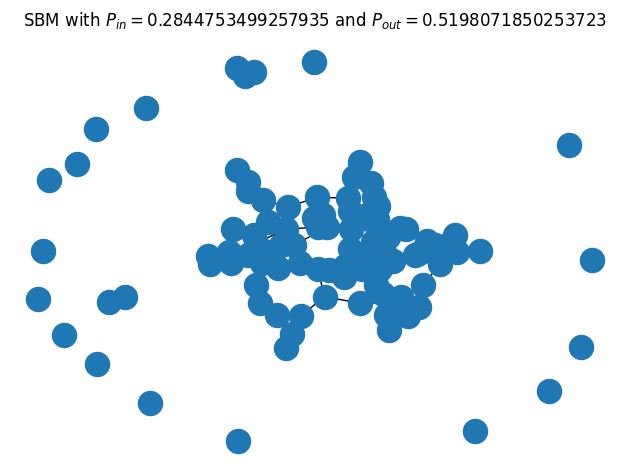

In [5]:
fig2, ax1 = plt.subplots()
Pii = np.random.rand()
Pij = np.random.rand()
nx.draw(G, ax=ax1)
ax1.set_title("SBM with $P_{{{}}}={}$ and $P_{{{}}}={}$".format('in', Pii, 'out', Pij))
fig2.tight_layout()
plt.show()

Modifying the RD to run a concurrent staggerred rollout on $\mathcal{U}'$ with t.p. $p'$.

In [6]:
import networkx as nx
import numpy as np

def seq_treatment_probs(beta, p):
  '''
  Returns sequence of treatment probabilities for Bernoulli staggered rollout

  beta (int): degree of the polynomial; order of interactions of the potential outcomes model
  p (float): treatment budget e.g. if you can treat 5% of population, p = 0.05
  '''
  fun = lambda i: (i)*p/(beta)
  P = np.fromfunction(fun, shape=(beta+1,))
  return P

def zU_to_z(z_U, U, z_U_prime, Uprime, n):
    '''
    Let U be the set of individuals randomized to treatment or control.
    This function takes the treatment assignment vector of U and returns
    the treatment assignment vector for the whole population (of size N=n*n).

    Parameters
    -----------
    z_U : array
        treatment assignment vector for nodes in U
    lst : list
        list of the nodes in U
    N : int
        size of the popluation (N=n*n)
    '''
    # Get the indices from [n_U] and [n_{Uprime}] of treated units
    treated_U = np.nonzero(z_U)[0]
    treated_U_prime = np.nonzero(z_U_prime)[0]

    # Get their corresponded indices in [N]
    treated_U = list(map(U.__getitem__, treated_U))
    treated_U_prime = list(map(Uprime.__getitem__, treated_U_prime))
    treated = treated_U + treated_U_prime
    
    # Create the treatment assignment vector of the whole population
    z = np.zeros(n)
    np.put(z,treated,1)

    return z

def staggered_rollout_bern(n, selected, P, bndry, P_prime):
  '''
  Returns Treatment Samples from Bernoulli Staggered Rollout

  n (int): size of population
  selected (list): list of the nodes who were selected to be in the staggered rollout experiment
  P (numpy array): treatment probabilities for each time step for the selected group
  bndry (list): boundary of selected (neighbors of nodes in selected who are not themselves selected)
  '''

  ### Initialize ###
  T = len(P)
  Z = np.zeros(shape=(T,n))   # for each treatment sample z_t
  W = np.random.rand(len(selected))
  W_prime = W = np.random.rand(len(bndry))

  ### staggered rollout experiment ###
  for t in range(T):
    ## sample treatment vector ##
    z_U = (W < P[t])+0
    z_U_prime = (W_prime < P_prime[t])+0
    Z[t,:] = zU_to_z(z_U, selected, n)

  return Z

In [2]:
n = 10
lst = [2,4,6,8]
bndry = [0,9]
p = 0.75
p_prime = 0

W = np.random.rand(len(lst))
W_prime = np.random.rand(len(bndry))

z_U = (W < p)+0
z_U_prime = (W_prime < p_prime)+0

print(z_U)
print(z_U_prime)

z = zU_to_z(z_U, lst, z_U_prime, bndry, n)
print(z)

[1 1 0 0]
[0 0]
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]


In [3]:
n = 10
lst = [2,4,6,8]
bndry = [0,9]
p = 0.75
p_prime = 0.75

W = np.random.rand(len(lst))
W_prime = np.random.rand(len(bndry))

z_U = (W < p)+0
z_U_prime = (W_prime < p_prime)+0

print(z_U)
print(z_U_prime)

z = zU_to_z(z_U, lst, z_U_prime, bndry, n)
print(z)

[0 1 1 0]
[0 1]
[0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]


In [7]:
n = 10
lst = [2,4,6,8]
bndry = []
p = 0.75
p_prime = 0

W = np.random.rand(len(lst))
W_prime = np.random.rand(len(bndry))

z_U = (W < p)+0
z_U_prime = (W_prime < p_prime)+0

print(z_U)
print(z_U_prime)

z = zU_to_z(z_U, lst, z_U_prime, bndry, n)
print(z)

[1 0 1 1]
[]
[0. 0. 1. 0. 0. 0. 1. 0. 1. 0.]


In [11]:
import numpy as np
import random
def color_nodes(n, K):
    '''
    int n = number of nodes
    int K = number of communities (assumed to be of equal size, with n divisible  by K)
    '''
    number_of_colors = K
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    rep = int(n/K)
    res = np.repeat(color, rep)
    return res

In [12]:
res = color_nodes(20, 4)
print(res)

['#3BFB49' '#3BFB49' '#3BFB49' '#3BFB49' '#3BFB49' '#3E1EF0' '#3E1EF0'
 '#3E1EF0' '#3E1EF0' '#3E1EF0' '#0D3FD1' '#0D3FD1' '#0D3FD1' '#0D3FD1'
 '#0D3FD1' '#663740' '#663740' '#663740' '#663740' '#663740']
